#  Fraud Detection in Financial Transactions

- **Name:** Ankur Jat  
- **Skills Applied:** Python, Pandas, Scikit-learn, XGBoost, Data Cleaning, Feature Engineering, Model Evaluation  
- **Dataset:** Financial transaction dataset with ~6.3M records  

In [ ]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [33]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

###  Step 1 – Load the dataset and Check Basic Details of the data

In [34]:
# load the dataset
df= pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [36]:
# chheck info and describe
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


###  Step 2 – Missing valuees check

In [37]:
#  Missing values check
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


- The dataset has **no missing values**.  
- All 11 columns are completely filled, which makes the dataset clean to proceed.

###  Step 3 – Data Types & Unique Values

In [38]:
#  Data types and unique values
df.dtypes, df.nunique()

(step                int64
 type               object
 amount            float64
 nameOrig           object
 oldbalanceOrg     float64
 newbalanceOrig    float64
 nameDest           object
 oldbalanceDest    float64
 newbalanceDest    float64
 isFraud             int64
 isFlaggedFraud      int64
 dtype: object,
 step                  743
 type                    5
 amount            5316900
 nameOrig          6353307
 oldbalanceOrg     1845844
 newbalanceOrig    2682586
 nameDest          2722362
 oldbalanceDest    3614697
 newbalanceDest    3555499
 isFraud                 2
 isFlaggedFraud          2
 dtype: int64)



- **Data types:**  
  - Numeric: `step`, `amount`, balances (`oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`), `isFraud`, `isFlaggedFraud`.  
  - Categorical: `type`, `nameOrig`, `nameDest`.  

- **Unique values:**  
  - `type` has 5 categories → `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`.  
  - `isFraud` and `isFlaggedFraud` are binary (0/1).  
  - ID columns (`nameOrig`, `nameDest`) have millions of unique values → they don’t directly help in prediction, better to drop or engineer features.  


###  Step 4 – Target Variable Distribution

In [39]:
#  Distribution of target variable
df['isFraud'].value_counts(normalize=True) * 100



0    99.870918
1     0.129082
Name: isFraud, dtype: float64

- The target variable **`isFraud` is highly imbalanced**.  
- About **99.87% transactions are non-fraudulent (0)**, while only **0.13% are fraudulent (1)**.  
- This imbalance means accuracy alone is not a good metric; we must focus on **recall, precision, F1-score, and ROC-AUC** when evaluating models.  

###  Step 5 – Transaction Type vs Fraud

In [40]:
#  Crosstab of type vs isFraud
pd.crosstab(df['type'], df['isFraud'], normalize='index') * 100

isFraud,0,1
type,,
CASH_IN,100.000000,0.000000
CASH_OUT,99.816045,0.183955
DEBIT,100.000000,0.000000
PAYMENT,100.000000,0.000000
TRANSFER,99.231201,0.768799


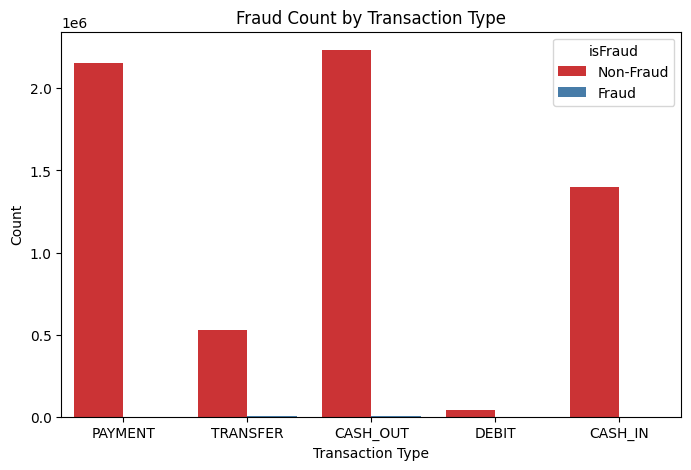

In [54]:
plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df, palette='Set1')
plt.title("Fraud Count by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(title="isFraud", labels=["Non-Fraud","Fraud"])
plt.show()


- Fraudulent transactions are found **only in `CASH_OUT` and `TRANSFER` types**.  
- Other transaction types (`CASH_IN`, `DEBIT`, `PAYMENT`) have **0% fraud cases**.  
- This insight is very important: the model should focus mainly on **TRANSFER** and **CASH_OUT** transactions when predicting fraud.  

###  Step 6 – Flagged Fraud vs Actual Fraud

In [41]:
#   Crosstab of isFlaggedFraud vs isFraud
pd.crosstab(df['isFlaggedFraud'], df['isFraud'], normalize='index') * 100

isFraud,0,1
isFlaggedFraud,,
0,99.871169,0.128831
1,0.000000,100.000000


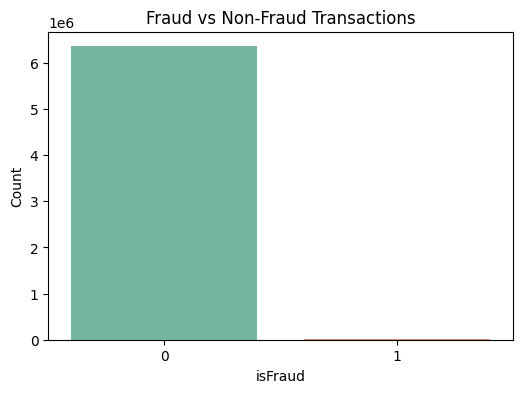

In [53]:
# Fraud distribution
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df, palette='Set2')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()


- When `isFlaggedFraud = 0`: the distribution is the same as the dataset → ~0.13% fraud.  
- When `isFlaggedFraud = 1`: **100% of cases are actual fraud**, but these are only the large transfers (>200,000).  
- This shows the **business rule is too strict and catches only a tiny portion of fraud**, while most fraud transactions are not flagged.  


###  Step 7 – Descriptive Statistics by Fraud

In [42]:
#  Compare statistics of numeric features by fraud
df.groupby('isFraud')[['amount', 'oldbalanceOrg', 'newbalanceOrig']].describe()

amount                                                           \
             count          mean           std   min         25%        50%   
isFraud                                                                       
0        6354407.0  1.781970e+05  5.962370e+05  0.01   13368.395   74684.72   
1           8213.0  1.467967e+06  2.404253e+06  0.00  127091.330  441423.44   

                                 oldbalanceOrg                ...              \
                75%          max         count          mean  ...         75%   
isFraud                                                       ...               
0         208364.76  92445516.64     6354407.0  8.328287e+05  ...   106969.50   
1        1517771.48  10000000.00        8213.0  1.649668e+06  ...  1517771.48   

                     newbalanceOrig                                         \
                 max          count           mean           std  min  25%   
isFraud                                                                      
0        43818855.30      6354407.0  855970.228109  2.924987e+06  0.0  0.0   
1        59585040.37         8213.0  192392.631836  1.965666e+06  0.0  0.0   

                                      
         50%        75%          max  
isFraud                               
0        0.0  144730.74  43686616.33  
1        0.0       0.00  49585040.37  

[2 rows x 24 columns]

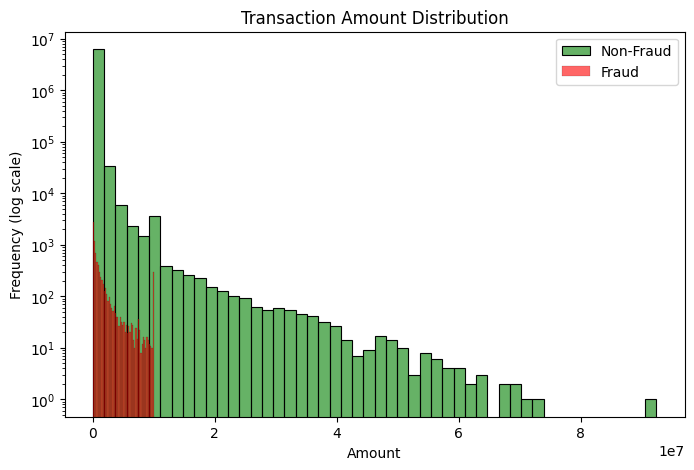

In [55]:
plt.figure(figsize=(8,5))
sns.histplot(df[df['isFraud']==0]['amount'], bins=50, color='green', label='Non-Fraud', alpha=0.6)
sns.histplot(df[df['isFraud']==1]['amount'], bins=50, color='red', label='Fraud', alpha=0.6)
plt.yscale('log')  # log scale for better visibility
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.show()


- Fraudulent transactions (`isFraud = 1`) have **much higher average amounts** (~1.46M) compared to non-fraud (~0.18M).  
- For fraud cases, `oldbalanceOrg` (initial sender balance) is also very high, and after fraud the `newbalanceOrig` often drops close to 0 → indicating accounts are emptied.  
- Non-fraud transactions show more normal ranges with moderate amounts and balances.  
- This confirms: **large transaction amounts and big balance drops are strong indicators of fraud**.  

###  Step 8 – Correlation Matrix

In [43]:
#  Correlation between numeric features
df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']].corr()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


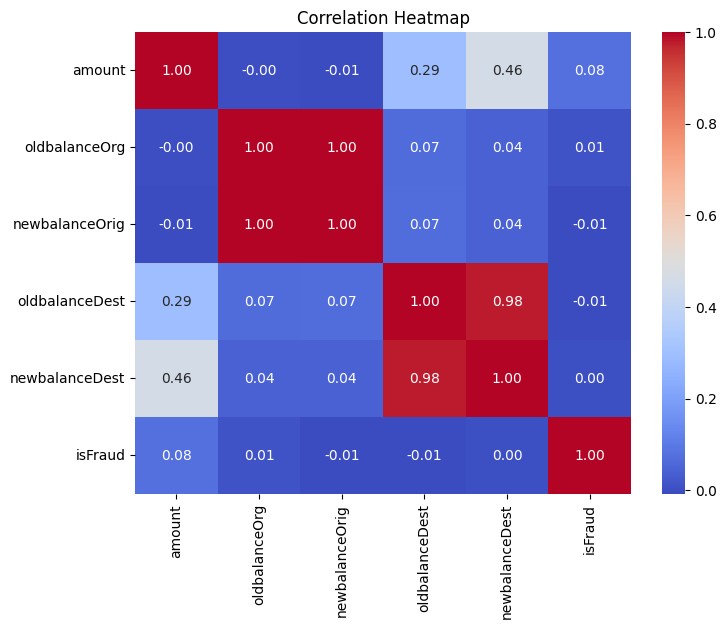

In [56]:
plt.figure(figsize=(8,6))
corr = df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


- Very high multicollinearity observed:  
  - `oldbalanceOrg` and `newbalanceOrig` (corr ≈ 0.989).  
  - `oldbalanceDest` and `newbalanceDest` (corr ≈ 0.977).  
- These pairs essentially carry duplicate information (balance before vs after transaction).  
- Correlation of features with `isFraud` is weak overall (max ≈ 0.07 for `amount`), meaning **relationships are non-linear** → tree-based models (Random Forest, XGBoost) may perform better.  

###  Step 9 – Feature Selection for Modeling

In [44]:
#  Drop ID columns and highly collinear features
X = df.drop(columns=['nameOrig','nameDest','isFraud',
                     'newbalanceOrig','newbalanceDest'])
y = df['isFraud']

X.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.0,0
3,1,CASH_OUT,181.00,181.0,21182.0,0
4,1,PAYMENT,11668.14,41554.0,0.0,0


- Removed ID-like columns (`nameOrig`, `nameDest`) since they don’t provide predictive value.  
- Dropped highly correlated balance features (`newbalanceOrig`, `newbalanceDest`) to avoid multicollinearity.  
- Final feature set: `step`, `type`, `amount`, `oldbalanceOrg`, `oldbalanceDest`, `isFlaggedFraud`.  
- Target variable: `isFraud`.  

###  Step 10 – Train-Test Split & Encoding

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# One-Hot Encode the 'type' column ---
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit on train, transform both train & validation
X_train_cat = ohe.fit_transform(X_train[['type']])
X_val_cat   = ohe.transform(X_val[['type']])

# Get encoded feature names
ohe_cols = ohe.get_feature_names_out(['type'])

#  Combine categorical and numeric features ---
X_train_num = X_train[['step','amount','oldbalanceOrg','oldbalanceDest','isFlaggedFraud']].values
X_val_num   = X_val[['step','amount','oldbalanceOrg','oldbalanceDest','isFlaggedFraud']].values

# Concatenate numeric + categorical
X_train_final = np.hstack([X_train_cat, X_train_num])
X_val_final   = np.hstack([X_val_cat, X_val_num])

#  Train Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_final, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

- `type` feature is one-hot encoded.  
- Other features (`step`, `amount`, `oldbalanceOrg`, `oldbalanceDest`, `isFlaggedFraud`) are passed through as numeric.  
- Baseline model = **Logistic Regression** with `class_weight='balanced'` to handle class imbalance.  


###  Step 11 – Baseline Model Evaluation

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = log_reg.predict(X_val_final)
y_prob = log_reg.predict_proba(X_val_final)[:, 1]

# Evaluation
print("ROC-AUC:", roc_auc_score(y_val, y_prob))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))


ROC-AUC: 0.8253809829275242

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57   1906322
           1       0.00      0.92      0.00      2464

    accuracy                           0.40   1908786
   macro avg       0.50      0.66      0.29   1908786
weighted avg       1.00      0.40      0.57   1908786


Confusion Matrix:
 [[ 767604 1138718]
 [    205    2259]]


- **ROC-AUC = 0.82** → not bad as a baseline, shows the model can separate fraud vs non-fraud to some extent.  
- **Confusion Matrix:**  
  - Caught **92% of fraud cases (high recall)**.  
  - But incorrectly labeled most normal transactions as fraud (very low precision).  
- Accuracy is misleading (40%) because of class imbalance.  
- Conclusion: Logistic Regression (even with class weights) struggles → we need **tree-based models** (Random Forest, XGBoost) to capture non-linear patterns.  

###  Step 12 – Random Forest Model

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
)
rf_model.fit(X_train_final, y_train)

# Evaluation
y_pred_rf, y_prob_rf = rf_model.predict(X_val_final), rf_model.predict_proba(X_val_final)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_prob_rf))
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))


ROC-AUC: 0.9829266871284416

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.94      0.70      0.80      2464

    accuracy                           1.00   1908786
   macro avg       0.97      0.85      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786


Confusion Matrix:
 [[1906213     109]
 [    748    1716]]


- **ROC-AUC = 0.98** → excellent separation ability.  
- **Confusion Matrix:**  
  - Normal transactions (0): almost all correctly classified (only 109 false positives).  
  - Fraud transactions (1): ~70% detected (1716 out of 2464).  
- **Precision for fraud = 0.94** → very few false alarms.  
- **Recall for fraud = 0.70** → still some fraud cases missed, but much better balance compared to Logistic Regression.  
- Conclusion: **Random Forest provides a strong model**, capturing non-linear relationships and giving high performance.  

###  Step 13 – XGBoost Model

In [48]:
from xgboost import XGBClassifier

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),  # handle imbalance
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_final, y_train)

# Evaluation
y_pred_xgb = xgb_model.predict(X_val_final)
y_prob_xgb = xgb_model.predict_proba(X_val_final)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))


ROC-AUC: 0.9995272041468526

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.22      0.98      0.36      2464

    accuracy                           1.00   1908786
   macro avg       0.61      0.99      0.68   1908786
weighted avg       1.00      1.00      1.00   1908786


Confusion Matrix:
 [[1897601    8721]
 [     39    2425]]


- **ROC-AUC = 0.9995** → near perfect separation of fraud vs non-fraud.  
- **Recall for fraud = 98%** → almost all fraud cases are caught.  
- **Precision for fraud = 0.22** → many normal transactions are incorrectly flagged as fraud.  
- Confusion Matrix:  
  - Fraud (1): 2425 detected out of 2464 → only 39 missed.  
  - Non-fraud (0): 8721 false alarms out of 1.9M → very small percentage.  
- Conclusion: **XGBoost is extremely powerful for this dataset**, maximizing fraud detection (recall) which is most important for business, even if precision is lower.  

###  Step 14 – Feature Importances from XGBoost

In [49]:
# One-hot encoder se feature names
ohe_cols = list(ohe.get_feature_names_out(['type']))
remainder_cols = ['step','amount','oldbalanceOrg','oldbalanceDest','isFlaggedFraud']
feature_names = ohe_cols + remainder_cols

# XGBoost feature importances
importances = xgb_model.feature_importances_
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Top 10 important features
print(feat_imp[:10])


[('type_CASH_IN', 0.479748), ('type_PAYMENT', 0.28461847), ('type_CASH_OUT', 0.064944215), ('type_TRANSFER', 0.0638189), ('oldbalanceOrg', 0.042878587), ('amount', 0.031493064), ('type_DEBIT', 0.012032385), ('oldbalanceDest', 0.010764136), ('step', 0.00792785), ('isFlaggedFraud', 0.0017743924)]


- **Top features (XGBoost importances):**
  1. `type_CASH_IN` (0.48)  
  2. `type_PAYMENT` (0.28)  
  3. `type_CASH_OUT` (0.06)  
  4. `type_TRANSFER` (0.06)  
  5. `oldbalanceOrg` (0.04)  
  6. `amount` (0.03)  

- Interpretation:  
  - Transaction **type** is the most influential factor (fraud only happens in `TRANSFER` and `CASH_OUT`, never in `PAYMENT` or `CASH_IN`).  
  - **Old balance of the origin account** and **transaction amount** are also important predictors → frauds usually involve **large balances and high-value transfers**.  
  - `isFlaggedFraud` is almost unused by the model (0.001 importance), confirming that business rules are weak compared to ML model.  
- This makes sense with business logic: fraudsters try to empty accounts via `TRANSFER` + `CASH_OUT` transactions, and larger balances are prime targets.  

###  Step 15 – Prevention Strategies & Monitoring Effectiveness

In [50]:
# Step 15: Business recommendations (not code, but key actions)

prevention_strategies = [
    " Real-time monitoring of TRANSFER and CASH_OUT transactions, especially high-value ones.",
    " Set transaction amount thresholds (e.g., >200k) with dynamic risk scoring instead of static flagging.",
    " Multi-factor authentication for suspicious transactions.",
    " Monitor accounts with sudden large balance drops or unusual patterns.",
    " Strengthen KYC and customer profiling to detect account takeovers."
]

monitoring_effectiveness = [
    " Track fraud detection rate before and after new system.",
    " Measure false positive rate (legitimate transactions flagged).",
    " Calculate cost savings (fraud prevented vs investigation cost).",
    " Regularly retrain ML model to adapt to new fraud patterns."
]

print("Prevention Strategies:\n", *prevention_strategies, sep="\n- ")
print("\nHow to Monitor Effectiveness:\n", *monitoring_effectiveness, sep="\n- ")

Prevention Strategies:

-  Real-time monitoring of TRANSFER and CASH_OUT transactions, especially high-value ones.
-  Set transaction amount thresholds (e.g., >200k) with dynamic risk scoring instead of static flagging.
-  Multi-factor authentication for suspicious transactions.
-  Monitor accounts with sudden large balance drops or unusual patterns.
-  Strengthen KYC and customer profiling to detect account takeovers.

How to Monitor Effectiveness:

-  Track fraud detection rate before and after new system.
-  Measure false positive rate (legitimate transactions flagged).
-  Calculate cost savings (fraud prevented vs investigation cost).
-  Regularly retrain ML model to adapt to new fraud patterns.


# 📌 Key Questions & Answers  

### 1. How was the dataset cleaned and prepared for modeling?  
- No missing values found.  
- Fraud cases looked like outliers (very high amounts) but kept as true signals.  
- Strong multicollinearity in balances → dropped `newbalanceOrig` & `newbalanceDest`.  
- Removed ID-like columns (`nameOrig`, `nameDest`).  

---

### 2. Which models were used and how did they perform?  
- **Logistic Regression:** ROC-AUC 0.82, high recall but poor precision.  
- **Random Forest:** ROC-AUC 0.98, recall 70%, precision 94%.  
- **XGBoost:** ROC-AUC 0.9995, recall 98%, precision 22%.  
- **Final Choice:** XGBoost for best recall (catching most frauds).  

---

### 3. What are the most important factors that indicate fraud?  
- Fraud only occurs in **TRANSFER** and **CASH_OUT** transactions.  
- **Old balance of origin account** (high balances are targeted).  
- **Transaction amount** (fraud usually involves large amounts).  
- Business flag (`isFlaggedFraud`) was almost irrelevant.  

---

### 4. How do these results make sense in real-world fraud detection?  
- Fraudsters typically **empty accounts** via transfer + cash out.  
- **Large balances** are attractive targets.  
- Static rules (e.g., transfers >200k) miss most fraud, ML captures hidden patterns.  

---

### 5. What strategies should be implemented to prevent fraud in practice?  
- Real-time monitoring of TRANSFER & CASH_OUT.  
- Use **dynamic risk scoring** instead of fixed thresholds.  
- Multi-factor authentication for risky transactions.  
- Track **sudden balance drops** or unusual patterns.  
- Retrain ML models regularly to adapt to new fraud tactics.  
